# Libraries

In [1]:
import numpy as np

import os

import pandas as pd

import seaborn as sns

# Add the ../src directory to the Python path
import sys
sys.path.append(os.path.abspath(os.path.join('..')))

from src import adjust_column_names

# Data Import

In [2]:
source_data = pd.read_csv(
    os.path.join('..', 'data', 'insurance_data_sample.csv'),
    sep=',',
    encoding='utf-8',
    parse_dates=['Date'],
    dtype={'Phone': str})

# Preprocessing

In [3]:
prep_data = source_data.copy()

## Adjust column names

In [4]:
prep_data = adjust_column_names(prep_data)

# Analysis

## One dealer no has multiple dealer names

In [5]:
prep_data\
    .groupby(['dealer_no', 'dealer_name'])\
    .agg(
        nr_of_cars=pd.NamedAgg('car_id', 'count'))

nr_of_cars
dealer_no  dealer_name                                                
06457-3834 Buddy Storbeck's Diesel Service Inc                     627
           Diehl Motor CO Inc                                      624
           Nebo Chevrolet                                          633
           Ryder Truck Rental and Leasing                         1248
38701-8047 Capitol KIA                                             628
           Gartner Buick Hyundai Saab                              628
           Pars Auto Sales                                         630
           Scrivener Performance Engineering                      1246
53546-9427 Chrysler Plymouth                                       625
           Iceberg Rentals                                         627
           Progressive Shippers Cooperative Association No        1318
           Suburban Ford                                          1243
60504-7114 C & M Motors Inc                                        625
           Enterprise Rent A Car                                   625
           New Castle Ford Lincoln Mercury                         629
           Saab-Belle Dodge                                       1251
78758-7841 Clay Johnson Auto Sales                                 627
           Motor Vehicle Branch Office                             626
           Race Car Help                                          1253
           U-Haul CO                                              1247
85257-3102 Classic Chevy                                           623
           McKinney Dodge Chrysler Jeep                            629
           Rabun Used Car Sales                                   1313
           Tri-State Mack Inc                                     1249
99301-3882 Chrysler of Tri-Cities                                  626
           Hatfield Volkswagen                                     629
           Pitre Buick-Pontiac-Gmc of Scottsdale                   628
           Star Enterprises Inc                                   1249

## Phone belongs to multiple customers

In [6]:
# example
prep_data.query('phone == "6015528"')

,car_id,date,customer_name,gender,annual_income,dealer_name,company,model,engine,transmission,color,price_usd,dealer_no,body_style,phone,amount_paid_for_insurance,claim_amount,city
618,C_CND_000619,2022-02-27,Clement,Male,1480000,Ryder Truck Rental and Leasing,Dodge,Intrepid,Overhead Camshaft,Manual,Black,11000,06457-3834,Sedan,6015528,814,0.0,Daugavpils
2814,C_CND_002815,2022-05-31,Benjamin,Male,1381500,Hatfield Volkswagen,Plymouth,Voyager,Overhead Camshaft,Manual,Red,20150,99301-3882,Passenger,6015528,1458,2015.0,Ventspils


In [7]:
# overall stats
prep_data\
    .groupby(['phone'])\
    .agg(
        nr_of_customer_names=pd.NamedAgg('customer_name', 'nunique'))\
    .query('nr_of_customer_names > 1')

,nr_of_customer_names
phone,
6005535,2
6015528,2
6049609,2
6051637,2
6105197,2
...,...
8850757,2
8870641,2
8895808,2


## Price contains high variation for same car configuration

For the combination of company/model/engine/transmission/body_style, there could be outliers

Text(0.5, 1.0, 'Distribution of iqr scores where there is price difference more than 5k.')

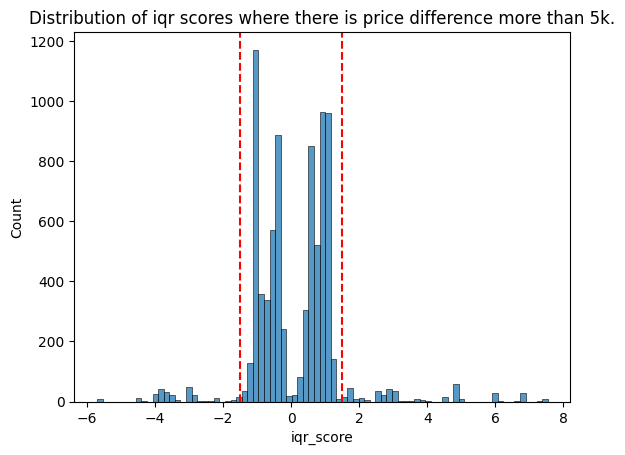

In [14]:
def calculate_iqr(x):
    Q1 = x.quantile(0.25)
    Q3 = x.quantile(0.75)
    return Q3 - Q1

df = prep_data.copy()
df.loc[:, 'car_config'] = df.loc[:, ['company', 'model', 'engine', 'transmission', 'body_style']]\
    .astype(str)\
    .apply(lambda x: '|'.join(x), axis=1)

df_2 = df\
    .groupby('car_config')\
    .agg(
        iqr=pd.NamedAgg('price_usd', calculate_iqr),
        minimum=pd.NamedAgg('price_usd', 'min'),
        maximum=pd.NamedAgg('price_usd', 'max'),
        median=pd.NamedAgg('price_usd', 'median'))\
    .reset_index()

df_3 = df\
    .loc[:, ['car_id', 'car_config', 'price_usd']]\
    .merge(
        right=df_2.loc[:, ['car_config', 'median', 'iqr']],
        left_on='car_config',
        right_on='car_config')

df_3.loc[:, 'iqr_score'] = (df_3.loc[:, 'price_usd'] - df_3.loc[:, 'median']) / df_3.loc[:, 'iqr']

df_4 = df_3\
    .query('-9 < iqr_score < 9')\
    .query('abs(price_usd - median) > 5000')\
    .copy()

g = sns.histplot(df_4, x='iqr_score')

g.axvline(x=1.50, color='red', linestyle='--')
g.axvline(x=-1.50, color='red', linestyle='--')

g.set_title('Distribution of iqr scores where there is price difference more than 5k.')